In [20]:
import time

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer

#Counts number of repetitions of elements in a list
from collections import Counter

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#Imports utils. A customed module. 

#### Download the data from url as zip and store it and load it. If it is already downloaded then just load it. 

In [21]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def download_and_read_text():

    if not isfile(dataset_filename):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
            urlretrieve(
                'http://mattmahoney.net/dc/text8.zip',
                dataset_filename,
                pbar.hook)

    if not isdir(dataset_folder_path):
        with zipfile.ZipFile(dataset_filename) as zip_ref:
            zip_ref.extractall(dataset_folder_path)
            
    with open('data/text8') as f:
        text = f.read()


    return text



In [22]:
def clean_text(text_string, min_num_appearances = 5):
    # Replace punctuation with tokens so we can use them in our model
    text = text_string.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in tqdm(words) if word_counts[word] > min_num_appearances]

    return trimmed_words

In [23]:
def fit_tokenizer(cleaned_text_list, oov_token = '<OOV>', num_words = None):
    #This function is just to eliminate the training of the Tokenizer object. Big drawbacks
    #we cannot change hyperparams.

    tokenizer = Tokenizer(oov_token = oov_token, num_words = num_words)
    tokenizer.fit_on_texts(cleaned_text_list)

    return tokenizer

In [24]:
def single_word_pair(text_list, index, window_size = 5):
    
    num_words = len(text_list)

    rand_window = np.random.randint(1, window_size +1)

    start_index = (index - rand_window) if (index - rand_window) > 0 else 0 

    end_index = (index + rand_window) if (index + rand_window) < num_words else num_words - 1

    word_list = set(text_list[start_index : index] + text_list[index + 1 : end_index])
    
    pairs = [(text_list[index], word) for word in word_list]

    return pairs

The following function would be better as a generator to help save space. Further adjustments. 

In [25]:
def word_pair(text_list, window_size = 5):

    word_pairs = []

    for word_index in tqdm(range(len(text_list))):

        word_pairs += single_word_pair(text_list, word_index, window_size = window_size)

    word_pairs = np.array(word_pairs)

    return word_pairs

This has has to have a better approach with the object. The idea is just to define the structure. 

In [59]:
class SkipGram():

    def __init__(self):
        self.params = None
        self.model = None
        self.trained_model = None

    
    def set_params(self, new_params):

        self.params = new_params



#Must input a dict with 
    def create_model(self, num_words, activation = 'linear', name = 'projection_layer'):
        #Right now the params will be fixed. 
        
        num_words = fitted_tokenizer.num_words

        model = tf.keras.Sequential(
        [
        tf.keras.layers.Dense(300, activation = activation, name = name, input_shape = (num_words,)),
        tf.keras.layers.Dense(num_words, activation = 'softmax', name = 'output_layer')
        ]
        )

        return model
    
    def set_model(self, model):

        self.model = model


    
    def set_trained_model(self, model):

        self.trained_model = model



    def graph_errors(self, training_history):
        
        acc = training_history.history['accuracy']
        val_loss = training_history.history['val_loss']
        val_acc = training_history.history['val_accuracy']
        loss = training_history.history['loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'b', label='Training accuracy')
        plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
        plt.title('Training accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', label='Training Loss')
        plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
        plt.title('Loss')
        plt.legend()

        plt.show()

#### Download text

In [27]:
text = download_and_read_text()

## Data preprocessing

#### Cleaning text

In [28]:
cleaned_text = clean_text(text)

cleaned_text = cleaned_text[:5000]

100%|██████████| 17005207/17005207 [00:15<00:00, 1103165.26it/s]


#### Obtain word pairs

In [29]:
word_pairs = word_pair(cleaned_text, window_size = 5)

100%|██████████| 5000/5000 [00:00<00:00, 64755.69it/s]


In [30]:
X = word_pairs[:, 0]

y = word_pairs[:, 1]

In [31]:
display(X.shape)

display(y.shape)


(24058,)

(24058,)

#### Tokenizer

In [32]:
fitted_tokenizer = fit_tokenizer(cleaned_text, num_words = 500)

Transform words to vectors.

In [33]:
X_vec = fitted_tokenizer.texts_to_matrix(X)

y_vec = fitted_tokenizer.texts_to_matrix(y)

In [34]:
display(X_vec[:3])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Model


In [46]:
num_words = fitted_tokenizer.num_words

In [47]:
display(num_words)

500

#### Create model and holder.

In [60]:
skipgram = SkipGram()

skipgram_model = skipgram.create_model(num_words)

In [61]:

display(skipgram_model)

In [62]:
skipgram_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [63]:
print(skipgram_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection_layer (Dense)    (None, 300)               150300    
                                                                 
 output_layer (Dense)        (None, 500)               150500    
                                                                 
Total params: 300,800
Trainable params: 300,800
Non-trainable params: 0
_________________________________________________________________
None


#### Fiting model

In [43]:
history = skipgram_model.fit(X_vec, y_vec, validation_split = .2 ,epochs = 1, verbose = 1, batch_size = 5)

Epoch 1/10
3850/3850 [==============================] - 31s 8ms/step - loss: 4.8891 - accuracy: 0.1906 - val_loss: 4.6946 - val_accuracy: 0.2774
Epoch 2/10
3850/3850 [==============================] - 30s 8ms/step - loss: 4.5605 - accuracy: 0.1915 - val_loss: 4.7338 - val_accuracy: 0.2704
Epoch 3/10
3850/3850 [==============================] - 31s 8ms/step - loss: 4.3023 - accuracy: 0.1886 - val_loss: 4.8656 - val_accuracy: 0.2579
Epoch 4/10
3850/3850 [==============================] - 29s 7ms/step - loss: 4.1258 - accuracy: 0.1860 - val_loss: 4.9544 - val_accuracy: 0.2450
Epoch 5/10
3850/3850 [==============================] - 28s 7ms/step - loss: 4.0293 - accuracy: 0.1823 - val_loss: 5.0380 - val_accuracy: 0.2425
Epoch 6/10
3850/3850 [==============================] - 27s 7ms/step - loss: 3.9773 - accuracy: 0.1784 - val_loss: 5.1392 - val_accuracy: 0.2363
Epoch 7/10
3850/3850 [==============================] - 27s 7ms/step - loss: 3.9462 - accuracy: 0.1798 - val_loss: 5.1789 - val_ac

#### Updating holder with fitted_model

In [64]:
skipgram.set_trained_model(skipgram_model)

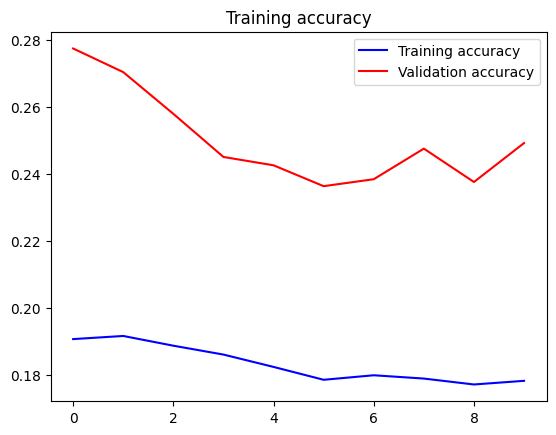

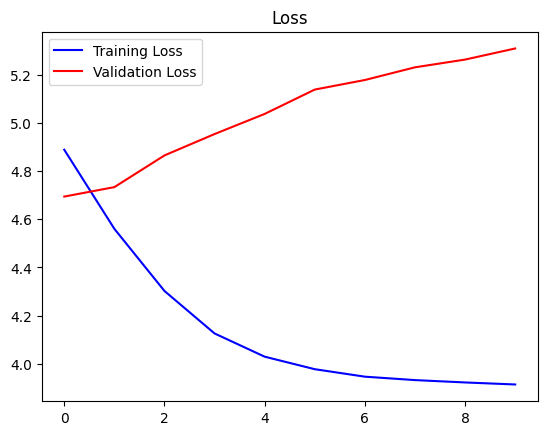

In [65]:
skipgram.graph_errors(history)

## Model Evaluation

### We want to access the parameters of the projection layer. 
 retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape (vocab_size, embedding_dimension)

In [ ]:
def cut_dict():
    
    n_words = 300

    aux_dict = {}

    for key, items in fitted_tokenizer.word_index.items():

        if items <= n_words:

            aux_dict[key] = items

In [ ]:
def write_projector_files(word_index, embedding_matrix)

    out_v = open('vecs.tsv', 'w')
    out_m = open('meta.tsv', 'w')
    for word, i in word_index.items():
        vec = embeddings_matrix[:, i-1]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_v.close()
    out_m.close()

In [44]:
display(weights.shape)

(500, 300)

In [53]:
display(len(fitted_tokenizer.word_index))

1412

In [57]:
display(fitted_tokenizer.word_index)

n_words = 300

aux_dict = {}

for key, items in fitted_tokenizer.word_index.items():

    if items <= n_words:

        aux_dict[key] = items

{'<OOV>': 1,
 'the': 2,
 'of': 3,
 'and': 4,
 'in': 5,
 'to': 6,
 'a': 7,
 'one': 8,
 'as': 9,
 'anarchism': 10,
 'zero': 11,
 'is': 12,
 's': 13,
 'that': 14,
 'anarchists': 15,
 'anarchist': 16,
 'nine': 17,
 'was': 18,
 'with': 19,
 'eight': 20,
 'it': 21,
 'by': 22,
 'anarcho': 23,
 'for': 24,
 'be': 25,
 'an': 26,
 'movement': 27,
 'from': 28,
 'or': 29,
 'two': 30,
 'first': 31,
 'most': 32,
 'his': 33,
 'this': 34,
 'they': 35,
 'on': 36,
 'its': 37,
 'some': 38,
 'such': 39,
 'society': 40,
 'are': 41,
 'three': 42,
 'he': 43,
 'property': 44,
 'many': 45,
 'also': 46,
 'movements': 47,
 'ideas': 48,
 'not': 49,
 'were': 50,
 'which': 51,
 'post': 52,
 'state': 53,
 'anarchy': 54,
 'seven': 55,
 'have': 56,
 'workers': 57,
 'capitalism': 58,
 'against': 59,
 'has': 60,
 'social': 61,
 'six': 62,
 'proudhon': 63,
 'see': 64,
 'cnt': 65,
 'feminist': 66,
 'four': 67,
 'called': 68,
 'groups': 69,
 'general': 70,
 'form': 71,
 'bakunin': 72,
 'often': 73,
 'early': 74,
 'what': 75

In [59]:

out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for word, i in aux_dict.items():
    vec = embeddings[:, i-1]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()
